<html><h1><center style="color:blue">Applying Machine Learning Models</center></h1></html>

In [23]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


<html><h1><p style="color:#5dbcd2">Loading Data form File</p></h1></html>

In [2]:
train = pd.read_csv('UCI_HAR_dataset/csv_files/train.csv')
test = pd.read_csv('UCI_HAR_dataset/csv_files/test.csv')
print(train.shape, test.shape)

(7352, 564) (2947, 564)


In [3]:
train.head(2)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING


### Making Data for Model

In [4]:
X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_train = train.ActivityName

X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_test = test.ActivityName

print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

X_train and y_train : ((7352, 561),(7352,))
X_test  and y_test  : ((2947, 561),(2947,))


<html><h1><p style="color:#44bcd8">Let's start modeling with our Dataset</p></h1></html>

#### Labels that are useful in plotting confusion matrix

In [5]:
labels=['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']

#### Let's make a function to plot the confusion matrix

In [6]:
plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Let's make a function to run any model specified

In [7]:
from datetime import datetime
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Greens):
    
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train, y_train)
    print('Done....!\n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('==> training time:- {}\n'.format(results['training_time']))
    
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done....!\n')
    results['testing_time'] = test_end_time - test_start_time
    print('==> testing time:- {}\n'.format(results['testing_time']))
    results['predicted'] = y_pred
   

    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('==> Accuracy:- {}\n'.format(accuracy))
   
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('\n ********Confusion Matrix********')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(6,6))
    plt.grid(b=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    print('****************| Classifiction Report |****************')
    classification_report = metrics.classification_report(y_test, y_pred)
   
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    return results
    
    

#### Make function to print the gridsearch Parameters

In [8]:
def print_grid_search_attributes(model):
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('\n\n==> Best Estimator:')
    print('\t{}\n'.format(model.best_estimator_))


    # parameters that gave best results while performing grid search
    print('\n==> Best parameters:')
    print('\tParameters of best estimator : {}'.format(model.best_params_))


    #  number of cross validation splits
    print('\n==> No. of CrossValidation sets:')
    print('\tTotal numbre of cross validation sets: {}'.format(model.n_splits_))


    # Average cross validated score of the best estimator, from the Grid Search 
    print('\n==> Best Score:')
    print('\tAverage Cross Validate scores of best estimator : {}'.format(model.best_score_))

    

<html><h1><p style="color:red">1. Logistic Regression with Grid Search</p></h1></html>

training the model..
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   11.6s finished


Done....!

==> training time:- 0:00:13.388577

Predicting test data
Done....!

==> testing time:- 0:00:00.015626

==> Accuracy:- 0.9582626399728538


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  0 431  57   0   0   3]
 [  0  15 517   0   0   0]
 [  0   0   0 493   2   1]
 [  0   0   0   4 403  13]
 [  0   0   0  27   1 443]]


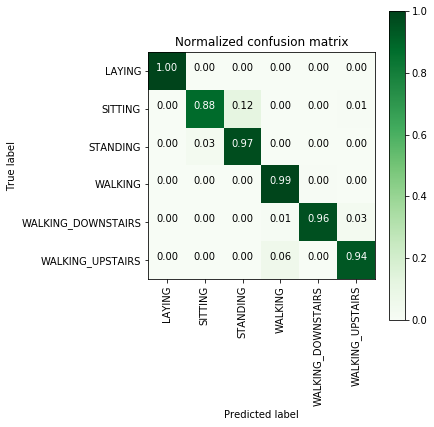

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.88      0.92       491
          STANDING       0.90      0.97      0.93       532
           WALKING       0.94      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.96      0.98       420
  WALKING_UPSTAIRS       0.96      0.94      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



==> Best Estimator:
	LogisticRegression(C=1)


==> Best parameters:
	Parameters of best estimator : {'C': 1, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total numbre of cross validation sets: 3

==> Best Score:
	Average Cross Validate scores of best estimator : 0.9367535671959523


In [11]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# start Grid search
parameters = {'C':[0.01, 0.1, 1, 10, 20, 30], 'penalty':['l2','l1']}
log_reg = linear_model.LogisticRegression()
log_reg_grid = GridSearchCV(log_reg, param_grid=parameters, cv=3, verbose=1, n_jobs=-1)
log_reg_grid_results =  perform_model(log_reg_grid, X_train, y_train, X_test, y_test, class_labels=labels)

# observe the attributes of the model 
print_grid_search_attributes(log_reg_grid_results['model'])


<html><h1><p style="color:red">2. Linear SVC with GridSearch</p></h1></html>

training the model..
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   42.1s finished


Done....!

==> training time:- 0:00:47.734722

Predicting test data
Done....!

==> testing time:- 0:00:00.009998

==> Accuracy:- 0.9647098744485918


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  2 423  62   0   0   4]
 [  0  10 521   1   0   0]
 [  0   0   0 496   0   0]
 [  0   0   0   2 412   6]
 [  0   0   0  17   0 454]]


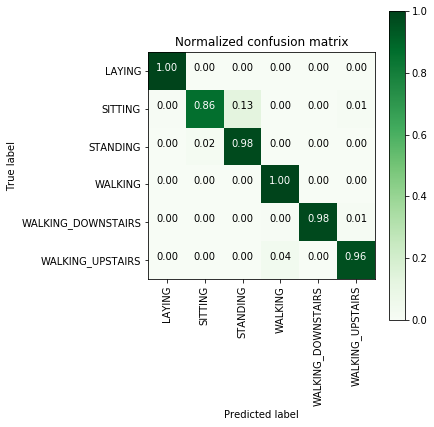

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.98      0.86      0.92       491
          STANDING       0.89      0.98      0.93       532
           WALKING       0.96      1.00      0.98       496
WALKING_DOWNSTAIRS       1.00      0.98      0.99       420
  WALKING_UPSTAIRS       0.98      0.96      0.97       471

          accuracy                           0.96      2947
         macro avg       0.97      0.96      0.96      2947
      weighted avg       0.97      0.96      0.96      2947



==> Best Estimator:
	LinearSVC(C=1, tol=5e-05)


==> Best parameters:
	Parameters of best estimator : {'C': 1}

==> No. of CrossValidation sets:
	Total numbre of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of best estimator : 0.9423363254207191


In [12]:
parameters = {'C':[0.125, 0.5, 1, 2, 8, 16]}
lr_svc = LinearSVC(tol=0.00005)
lr_svc_grid = GridSearchCV(lr_svc, param_grid=parameters, n_jobs=-1, verbose=1)
lr_svc_grid_results = perform_model(lr_svc_grid, X_train, y_train, X_test, y_test, class_labels=labels)

# observe the attributes of the model 
print_grid_search_attributes(lr_svc_grid_results['model'])

<html><h1><p style="color:red">3. Kernel SVM with GridSearch</p></h1></html>

training the model..
Done....!

==> training time:- 0:06:20.943907

Predicting test data
Done....!

==> testing time:- 0:00:01.547365

==> Accuracy:- 0.9626739056667798


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  0 441  48   0   0   2]
 [  0  12 520   0   0   0]
 [  0   0   0 489   2   5]
 [  0   0   0   4 397  19]
 [  0   0   0  17   1 453]]


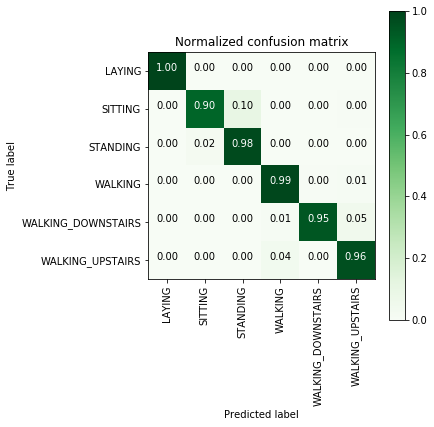

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.90      0.93       491
          STANDING       0.92      0.98      0.95       532
           WALKING       0.96      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.95      0.96      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



==> Best Estimator:
	SVC(C=16, gamma=0.0078125)


==> Best parameters:
	Parameters of best estimator : {'C': 16, 'gamma': 0.0078125}

==> No. of CrossValidation sets:
	Total numbre of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of best estimator : 0.9447834551903698


In [13]:
parameters = {'C':[2,8,16],\
              'gamma': [ 0.0078125, 0.125, 2]}
rbf_svm = SVC(kernel='rbf')
rbf_svm_grid = GridSearchCV(rbf_svm,param_grid=parameters, n_jobs=-1)
rbf_svm_grid_results = perform_model(rbf_svm_grid, X_train, y_train, X_test, y_test, class_labels=labels)

# observe the attributes of the model 
print_grid_search_attributes(rbf_svm_grid_results['model'])

<html><h1><p style="color:red">4. Decision Trees with GridSearchCV</p></h1></html>

training the model..
Done....!

==> training time:- 0:00:07.000424

Predicting test data
Done....!

==> testing time:- 0:00:00.015621

==> Accuracy:- 0.8646080760095012


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  0 386 105   0   0   0]
 [  0  93 439   0   0   0]
 [  0   0   0 471  17   8]
 [  0   0   0  13 346  61]
 [  0   0   0  78  24 369]]


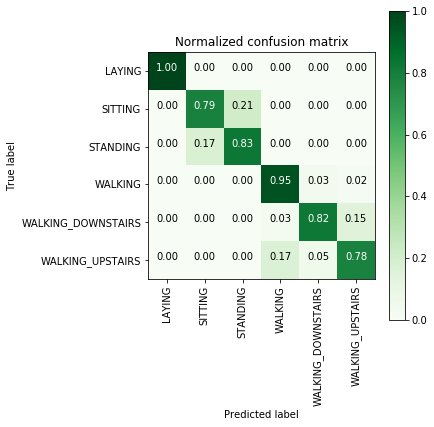

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.81      0.79      0.80       491
          STANDING       0.81      0.83      0.82       532
           WALKING       0.84      0.95      0.89       496
WALKING_DOWNSTAIRS       0.89      0.82      0.86       420
  WALKING_UPSTAIRS       0.84      0.78      0.81       471

          accuracy                           0.86      2947
         macro avg       0.86      0.86      0.86      2947
      weighted avg       0.87      0.86      0.86      2947



==> Best Estimator:
	DecisionTreeClassifier(max_depth=7)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 7}

==> No. of CrossValidation sets:
	Total numbre of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of best estimator : 0.8516117963160792


In [14]:
parameters = {'max_depth':np.arange(3,10,2)}
dt = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt,param_grid=parameters, n_jobs=-1)
dt_grid_results = perform_model(dt_grid, X_train, y_train, X_test, y_test, class_labels=labels)

# observe the attributes of the model 
print_grid_search_attributes(dt_grid_results['model'])

<html><h1><p style="color:red">5. Random Forest Classifier with GridSearch</p></h1></html>

training the model..
Done....!

==> training time:- 0:03:12.394065

Predicting test data
Done....!

==> testing time:- 0:00:00.043035

==> Accuracy:- 0.9260264675941635


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  0 430  61   0   0   0]
 [  0  45 487   0   0   0]
 [  0   0   0 478   8  10]
 [  0   0   0  18 360  42]
 [  0   0   0  27   7 437]]


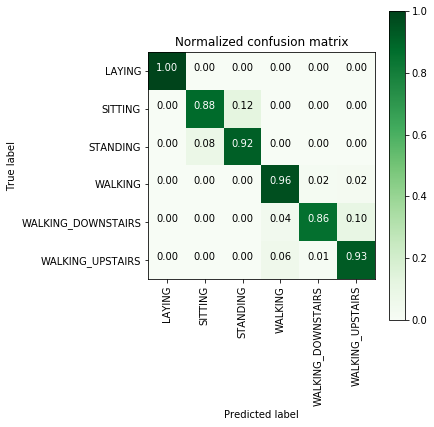

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.91      0.88      0.89       491
          STANDING       0.89      0.92      0.90       532
           WALKING       0.91      0.96      0.94       496
WALKING_DOWNSTAIRS       0.96      0.86      0.91       420
  WALKING_UPSTAIRS       0.89      0.93      0.91       471

          accuracy                           0.93      2947
         macro avg       0.93      0.92      0.92      2947
      weighted avg       0.93      0.93      0.93      2947



==> Best Estimator:
	RandomForestClassifier(max_depth=13, n_estimators=90)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 13, 'n_estimators': 90}

==> No. of CrossValidation sets:
	Total numbre of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of best estimator : 0.9212485374843343


In [15]:
params = {'n_estimators': np.arange(10,201,20), 'max_depth':np.arange(3,15,2)}
rfc = RandomForestClassifier()
rfc_grid = GridSearchCV(rfc, param_grid=params, n_jobs=-1)
rfc_grid_results = perform_model(rfc_grid, X_train, y_train, X_test, y_test, class_labels=labels)

# observe the attributes of the model 
print_grid_search_attributes(rfc_grid_results['model'])

<html><h1><p style="color:red">6. Gradient Boosted Decision Trees With GridSearch</p></h1></html>

In [ ]:
param_grid = {'max_depth': np.arange(5),'n_estimators':np.arange(140)}
gbdt = GradientBoostingClassifier()
gbdt_grid = GridSearchCV(gbdt, param_grid=param_grid, n_jobs=-1)
gbdt_grid_results = perform_model(gbdt_grid, X_train, y_train, X_test, y_test, class_labels=labels)

# observe the attributes of the model 
print_grid_search_attributes(gbdt_grid_results['model'])

<html><p style="color:blue"> NOTE: I am trying to run the "GradientBoostingClassifier()" with "GridSearchCV", but my system is not supported this pice of code. </p></html>

<html><h1><p style="color:red">7. Comparing all models</p></h1></html>

In [22]:
# ***************************** Print Accuracy and Error ******************************

print('\n                     Accuracy     Error')
print('                     ----------   --------')
print('Logistic Regression : {:.04}%       {:.04}%'.format(log_reg_grid_results['accuracy'] * 100,\
                                                  100-(log_reg_grid_results['accuracy'] * 100)))

print('Linear SVC          : {:.04}%       {:.04}% '.format(lr_svc_grid_results['accuracy'] * 100,\
                                                        100-(lr_svc_grid_results['accuracy'] * 100)))

print('rbf SVM classifier  : {:.04}%      {:.04}% '.format(rbf_svm_grid_results['accuracy'] * 100,\
                                                          100-(rbf_svm_grid_results['accuracy'] * 100)))

print('DecisionTree        : {:.04}%      {:.04}% '.format(dt_grid_results['accuracy'] * 100,\
                                                        100-(dt_grid_results['accuracy'] * 100)))

print('Random Forest       : {:.04}%      {:.04}% '.format(rfc_grid_results['accuracy'] * 100,\
                                                           100-(rfc_grid_results['accuracy'] * 100)))


                     Accuracy     Error
                     ----------   --------
Logistic Regression : 95.83%       4.174%
Linear SVC          : 96.47%       3.529% 
rbf SVM classifier  : 96.27%      3.733% 
DecisionTree        : 86.46%      13.54% 
Random Forest       : 92.6%      7.397% 


 - We can clearly choose here ___Linear SVC___ or ___rbf SVM___ as our ML Model.